Notebook for experimenting with Louvein community detection algorithm  
* on all the data together...

In [5]:
# Imports
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, jaccard_score, hamming_loss
import matplotlib.pyplot as plt

In [6]:
# Read data
responsories_all = pd.read_csv('../data/all-ci-responsories.csv', usecols=['cantus_id', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})
antiphons_all = pd.read_csv('../data/all-ci-antiphons.csv', usecols=['cantus_id', 'siglum', 'source_id', 'feast_id'], dtype={'cantus_id':"str"})

sources = pd.read_csv('../data/sources-with-provenance-ids-and-two-centuries.csv', usecols=['provenance_id', 'drupal_path'])
feasts = pd.read_csv('../data/feast.csv', usecols=['id', 'name'])

data = pd.concat([responsories_all, antiphons_all])

In [7]:
# Metrics for measuring similarity of two sets ('chant sharingness')
def intersection_size(a : list, b : list):
    '''
    Function returns size of intersection of two sets
    '''
    return len(set(a).intersection(set(b)))

def Jaccard_metrics(a : list, b : list):
    '''
    Function returns value of Jaccard metrics applied on two sets
    '''
    if len(set(a).union(set(b))) != 0:
        return (len(set(a).intersection(set(b))) / len(set(a).union(set(b))))
    else:
        return 0

In [8]:
# Source translate to int for smooth labels array indexing 
from collections import OrderedDict

source_dict = OrderedDict()
i = 0
for id in sources['drupal_path']:
    source_dict[id] = i
    i += 1
    

def translate_source(source_id):
    return source_dict[source_id]

In [9]:
def get_columns(metric, used_sources, source_chants_dict):
    
    len_s = len(used_sources)
    s1_column = [j for i in [len_s * [s] for s in used_sources] for j in i]
    s2_column = len_s * used_sources

    shared_column = []
    for i in range(len(s1_column)):
        s1_chants = source_chants_dict[s1_column[i]]
        s2_chants = source_chants_dict[s2_column[i]]
        shared_column.append(metric(s1_chants, s2_chants))
    
    return s1_column, s2_column, shared_column, used_sources

In [10]:
def get_graph(used_sources, source_chants_dict):
    s1_column, s2_column, shared_column, used_sources = get_columns(Jaccard_metrics, used_sources, source_chants_dict)
    nodes = used_sources
    edges = [(i, j, {'weight': round(w, 2) }) for i, j, w in zip(s1_column, s2_column, shared_column) if i != j and w != 0 and (i in used_sources and j in used_sources)]
    
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    
    return graph

In [11]:
def transform_to_labels(varinat):
    j = 0
    labels = np.zeros(len(sources))
    for community in varinat:
        for source in community:
            labels[translate_source(source)] = j
        j+=1
    return labels

In [12]:
drupals = sources['drupal_path'].tolist()
source_chants_dict_2 = {}
used_sources_2 = []

chants = data
for source_id in drupals:
    chants_of_source = [chant['cantus_id'] for index, chant in chants.iterrows() if chant['source_id'] == source_id]
    
    if chants_of_source != []:
        used_sources_2.append(source_id)
        try:
            source_chants_dict_2[source_id] += chants_of_source
        except:
            source_chants_dict_2[source_id] = chants_of_source

used_sources_2 = list(set(used_sources_2))

In [21]:
community_variants = []
num_of_clusters = []
max_jaccard = 0
max_rand = 0
max_mutual = 0
min_hamming = np.inf

graph = get_graph(used_sources_2, source_chants_dict_2)
for _ in range(20):
        variant = transform_to_labels(nx.community.louvain_communities(graph, weight='weight'))
        community_variants.append(variant)


In [22]:
for variant in community_variants:
    print(variant)

[3. 1. 1. 1. 1. 4. 4. 4. 1. 4. 1. 4. 1. 1. 4. 4. 4. 1. 4. 1. 1. 4. 4. 1.
 1. 3. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 4. 3. 1. 1. 1. 4. 1. 4. 1. 1. 1. 1.
 3. 1. 1. 1. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 4. 4. 1. 1. 3. 1. 1. 4.
 4. 1. 4. 1. 1. 1. 1. 1. 1. 1. 1. 2. 4. 1. 4. 2. 2. 2. 1. 1. 1. 3. 1. 1.
 1. 3. 3. 2. 1. 3. 3. 1. 2. 4. 2. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 3.
 3. 1. 3. 3. 1. 3. 1. 1. 1. 1. 1. 4. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 1. 1.
 1. 3. 3. 3. 3. 3. 1. 3. 3. 1. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 1. 1. 3. 3. 3. 3. 3. 3. 3. 2. 1. 3. 1. 1. 1. 1. 1. 3. 2. 1. 1. 3. 1. 3.
 3. 3. 3. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 3. 3. 1. 3. 2. 1. 1. 2. 1. 3. 3.
 2. 3. 1. 3. 2. 3. 1. 1.]
[1. 2. 2. 4. 2. 2. 2. 2. 4. 2. 4. 4. 4. 4. 2. 2. 2. 4. 2. 2. 2. 2. 2. 4.
 4. 1. 2. 2. 2. 2. 2. 2. 4. 4. 4. 4. 2. 1. 4. 4. 4. 2. 4. 2. 4. 4. 4. 4.
 1. 2. 2. 2. 2. 2. 4. 2. 2. 2. 4. 4. 2. 4. 4. 1. 2. 2. 4. 4. 1. 4. 4. 2.
 2. 2. 2. 2. 4. 4. 4. 4. 4. 4. 4. 3. 2. 4. 2. 3. 3. 3. 2. 4. 4. 1. 4. 4.
 2. 1. 1. 3. 4. 1. 1. 2. 

In [18]:
rand = []
jaccard = []
mutual_info = []
hamming = []
all_pairs = [(a, b) for idx, a in enumerate(community_variants) for b in community_variants[idx + 1:]]
for pair in all_pairs:
    rand.append(adjusted_rand_score(pair[0], pair[1]))
    mutual_info.append(adjusted_mutual_info_score(pair[0], pair[1]))
    jaccard.append(jaccard_score(pair[0], pair[1], average='micro'))
    hamming.append(hamming_loss(pair[0], pair[1]))

In [23]:
for com_var in community_variants:
    num_of_clusters.append(len(set(com_var)))

print('num_of_clusters', num_of_clusters)
print(np.mean(num_of_clusters))

num_of_clusters [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
4.0


rand [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.782698060328171, 1.0, 1.0, 0.782698

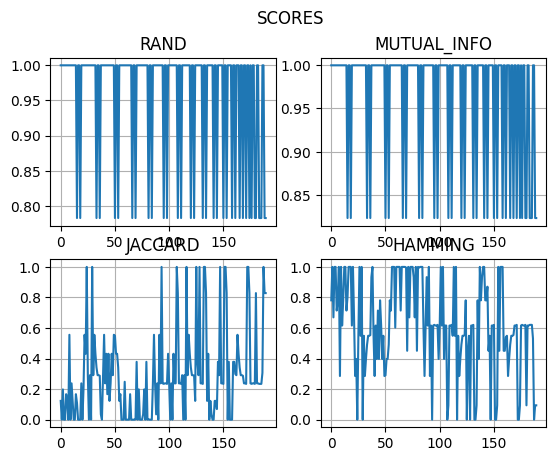

In [20]:
# Display results
print('rand', rand)
print('mutual_info', mutual_info)
print('jaccard', jaccard)
print('max jaccard', max(jaccard))
print('mean jaccard', np.mean(jaccard))
print('hamming', hamming)

plt.subplot(2, 2, 1)
plt.plot(rand)
plt.title('RAND')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(mutual_info)
plt.title('MUTUAL_INFO')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(jaccard)
plt.title('JACCARD')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(hamming)
plt.title('HAMMING')
plt.grid()

plt.suptitle('SCORES')
plt.show()